# モジュール準備

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import os
import random
import tarfile
from tqdm import tqdm
import xml.etree.ElementTree as ET
import pickle
import numpy as np
import pandas as pd
import statistics
import collections
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision

In [4]:
pd.options.display.max_columns = 200
pd.options.display.max_info_columns = 200
pd.options.display.max_info_rows = 1000
pd.options.display.max_colwidth = 200

In [5]:
# dataloaderのワーカー数
workers = 2

#  利用可能なGPUの数。CPUモードの場合は0を使用。
ngpu = 1

# どのデバイスで実行するかを決める
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# データ

In [10]:
# https://qiita.com/neuzen-ryuki/items/48fa468fa0b1c502ed1eから2019.tar.xzをダウンロードし、Google Driveに置いておく

local_folder_name = 'tenhou'
# os.mkdir(local_folder_name)

drive_folder_path = "/content/drive/MyDrive/mahjong/tenhou" # 2019.tar.xzを置いたフォルダパス
file_name = "2019.tar.xz"

with tarfile.open(os.path.join(drive_folder_path, file_name)) as tar:
    tar.extractall("/content/tenhou/")

In [ ]:
folder_path = "/content/tenhou/2019/"
files = os.listdir(folder_path)

gan_df = pd.DataFrame()

for file in tqdm(files[:40000]):
  test = ET.parse(os.path.join(folder_path, file))
  root = test.getroot()

  for child in root:
    if child.tag=="INIT":
      haipai_list= [
          child.attrib["hai0"],
          child.attrib["hai1"],
          child.attrib["hai2"],
          child.attrib["hai3"]
      ]

    elif child.tag=="AGARI":
      agari = pd.DataFrame(data = child.attrib, index=[0])
      haipai = haipai_list[int(agari["who"])]
      agari["haipai"] = haipai
      gan_df = pd.concat([gan_df, agari], ignore_index=True)

In [ ]:
print(len(gan_df))
gan_df.head()

In [26]:
def naki_treatment(x):
  if isinstance(x, str):
    furo_hai_id = [furo_to_hai(i) for i in x.split(",")]
    return sum(furo_hai_id, [])
  else:
    return []

In [27]:
def hai_convert_str(id):
  id_int = int(id)
  hai = ["一", "二", "三", "四", "五", "六", "七", "八", "九", #萬子
        "①", "②", "③", "④", "⑤", "⑥", "⑦", "⑧", "⑨", #筒子
        "1", "2", "3", "4", "5", "6", "7", "8", "9", #索子
        "東", "南", "西", "北", "白", "發", "中", np.nan, np.nan]
  return hai[id_int >> 2]

In [28]:
def furo_to_hai(furo):
  furo = int(furo)
  if (furo & 0x0004):                  # 順子の場合
      pattern = (furo & 0xFC00)>>10;          #「順子のパターン」を取得
      pattern = int(pattern / 3);
      color_id = int(pattern / 7);        # 萬子、筒子、索子を決定
      number = pattern % 7 + 1;                 # 1〜7を決定
      mentsu_num = [number, number+1, number+2];
      soezi = [(furo & 0x0018)>>3, (furo & 0x0060)>>5, (furo & 0x0180)>>7]; # 牌添字1〜3を取得
      mentsu = [color_id*9*4+(i-1)*4 + j for i, j in zip(mentsu_num, soezi)]
              
  elif (furo & 0x0018):               # 刻子、加槓の場合
      pattern = (furo & 0xFE00)>>9; #「刻子のパターン」を取得
      pattern = int(pattern / 3);
      color_id = int(pattern / 9);    # 萬子、筒子、索子、字牌を決定
      number = pattern % 9 + 1;                 # 1〜9を決定
      soezi = [0, 1, 2, 3]

      if (furo & 0x0008): # 刻子
        mentsu_num = [number, number, number];
        soezi_exclude = (furo & 0x0060)>>5
        soezi.remove(soezi_exclude)
        mentsu = [color_id*9*4+(i-1)*4 + j for i, j in zip(mentsu_num, soezi)]
        
      else: # 加槓
        mentsu_num = [number, number, number, number];
        mentsu = [color_id*9*4+(i-1)*4 + j for i, j in zip(mentsu_num, soezi)]
              
  else: # 暗槓、大明槓の場合
      pattern = (furo & 0xFF00)>>8;           #「槓子のパターン」を取得
      pattern = int(pattern / 4);
      color_id = int(pattern / 9);    # 萬子、筒子、索子、字牌を決定
      number = pattern % 9 + 1;                 # 1〜9を決定
      soezi = [0, 1, 2, 3]
      mentsu_num = [number, number, number, number];
      
      if (furo & 0x0003): # 大明槓
        mentsu = [color_id*9*4+(i-1)*4 + j for i, j in zip(mentsu_num, soezi)]
      else: # 暗槓
        mentsu = [color_id*9*4+(i-1)*4 + j for i, j in zip(mentsu_num, soezi)]

  mentsu_int = [int(i) for i in mentsu]
  return mentsu_int;

In [35]:
gan_df["haipai_id"] = gan_df.haipai.apply(lambda x: sorted([int(i) for i in  x.split(",")]))
gan_df["haipai_str"] = gan_df.haipai_id.apply(lambda x: [hai_convert_str(i) for i in  x])
gan_df["haipai_hai_id"] = gan_df.haipai_id.apply(lambda x: sorted([id_int >> 2 for id_int in x]))

gan_df["menzen_id"] = gan_df.hai.apply(lambda x: sorted([int(i) for i in  x.split(",")]))
gan_df["furo_id"] = gan_df.m.apply(lambda x: sorted(naki_treatment(x)))

gan_df["agari_id"] = gan_df[["menzen_id", "furo_id"]].apply(lambda x: sorted(x[1]+x[0]), axis=1)
gan_df["agari_str"] = gan_df.agari_id.apply(lambda x: [hai_convert_str(i) for i in x])
gan_df["agari_hai_id"] = gan_df.agari_id.apply(lambda x: sorted([id_int >> 2 for id_int in x]))

In [36]:
input_df = gan_df[["haipai_id", "haipai_str", "haipai_hai_id", "agari_id", "agari_str", "agari_hai_id"]]
input_df.head()

,haipai_id,haipai_str,haipai_hai_id,agari_id,agari_str,agari_hai_id
0,"[29, 38, 42, 45, 65, 69, 75, 85, 96, 115, 118, 125, 126]","[八, ①, ②, ③, ⑧, ⑨, 1, 4, 7, 南, 西, 白, 白]","[7, 9, 10, 11, 16, 17, 18, 21, 24, 28, 29, 31, 31]","[38, 42, 45, 69, 70, 85, 88, 94, 96, 101, 106, 124, 125, 126]","[①, ②, ③, ⑨, ⑨, 4, 5, 6, 7, 8, 9, 白, 白, 白]","[9, 10, 11, 17, 17, 21, 22, 23, 24, 25, 26, 31, 31, 31]"
1,"[6, 20, 22, 27, 50, 55, 65, 99, 101, 103, 108, 123, 124]","[二, 六, 六, 七, ④, ⑤, ⑧, 7, 8, 8, 東, 北, 白]","[1, 5, 5, 6, 12, 13, 16, 24, 25, 25, 27, 30, 31]","[5, 6, 20, 22, 23, 50, 55, 59, 91, 94, 99, 101, 102, 103]","[二, 二, 六, 六, 六, ④, ⑤, ⑥, 5, 6, 7, 8, 8, 8]","[1, 1, 5, 5, 5, 12, 13, 14, 22, 23, 24, 25, 25, 25]"
2,"[26, 43, 52, 61, 70, 74, 76, 80, 93, 98, 101, 112, 130]","[七, ②, ⑤, ⑦, ⑨, 1, 2, 3, 6, 7, 8, 南, 發]","[6, 10, 13, 15, 17, 18, 19, 20, 23, 24, 25, 28, 32]","[1, 7, 11, 52, 56, 61, 74, 76, 80, 93, 94, 98, 101, 104]","[一, 二, 三, ⑤, ⑥, ⑦, 1, 2, 3, 6, 6, 7, 8, 9]","[0, 1, 2, 13, 14, 15, 18, 19, 20, 23, 23, 24, 25, 26]"
3,"[10, 20, 22, 27, 33, 46, 59, 64, 71, 78, 124, 130, 134]","[三, 六, 六, 七, 九, ③, ⑥, ⑧, ⑨, 2, 白, 發, 中]","[2, 5, 5, 6, 8, 11, 14, 16, 17, 19, 31, 32, 33]","[20, 22, 26, 27, 52, 54, 58, 59, 117, 118, 124, 125, 130, 131]","[六, 六, 七, 七, ⑤, ⑤, ⑥, ⑥, 西, 西, 白, 白, 發, 發]","[5, 5, 6, 6, 13, 13, 14, 14, 29, 29, 31, 31, 32, 32]"
4,"[3, 25, 42, 43, 44, 47, 54, 70, 90, 100, 104, 126, 133]","[一, 七, ②, ②, ③, ③, ⑤, ⑨, 5, 8, 9, 白, 中]","[0, 6, 10, 10, 11, 11, 13, 17, 22, 25, 26, 31, 33]","[9, 10, 11, 38, 39, 42, 43, 44, 47, 84, 85, 90, 94, 96]","[三, 三, 三, ①, ①, ②, ②, ③, ③, 4, 4, 5, 6, 7]","[2, 2, 2, 9, 9, 10, 10, 11, 11, 21, 21, 22, 23, 24]"


## データセット化

In [37]:
class TehaiDataset(torch.utils.data.Dataset):
  def __init__(self, input_df):
    self.haipai_list = input_df["haipai_hai_id"].tolist()
    self.agari_list = input_df["agari_hai_id"].tolist()

  def __len__(self):
    return len(self.haipai_list)

  def __getitem__(self, index):
    haipai, agari = self.pull_item(index)
    return haipai, agari

  def tehai_2d(self, tehai):
    c = collections.Counter(tehai)
    tehai_ar = np.zeros(4*9*4)
    for i in c.items():
      hai_id = i[0] # 牌の種類 0index
      hai_times = i[1] # 枚数
      hai_id_list = [hai_id*4+i for i in range(hai_times)]
      for j in hai_id_list:
        tehai_ar[j] = 1
    tehai_m = tehai_ar[0:9*1*4].copy().reshape([-1, 4]) # 4, 9
    tehai_p = tehai_ar[9*1*4:9*2*4].copy().reshape([-1, 4])
    tehai_s = tehai_ar[9*2*4:9*3*4].copy().reshape([-1, 4])
    tehai_z = tehai_ar[9*3*4:].copy().reshape([-1, 4])
    tehai_ar = np.concatenate([tehai_m, tehai_p, tehai_s, tehai_z], 1)# 16. 9

    tehai_ar =  np.concatenate([tehai_ar, np.zeros((16-9)*16).reshape([-1, 16])], 0)# 16, 16

    return tehai_ar # チャンネル数、枚数、牌

  def pull_item(self, index):
    haipai = self.haipai_list[index]
    agari = self.agari_list[index]

    haipai_all = torch.tensor(np.array([self.tehai_2d(haipai)]), dtype=torch.float32)
    agari_all = torch.tensor(np.array([self.tehai_2d(agari)]), dtype=torch.float32)

    return haipai_all, agari_all

In [39]:
train_size = 0.7
train_df, test_df = train_test_split(input_df, train_size=train_size)

# データセットオブジェクトの作成
dataset_train = TehaiDataset(train_df)
dataset_test = TehaiDataset(test_df)

# データローダーオブジェクトの作成
batch_size = 512

train_dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,
                                              shuffle=True, num_workers=workers, pin_memory=True, drop_last=True)
test_dataloader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size,
                                              num_workers=workers, pin_memory=True)

# モデル（生成）

## ハイパラ

In [40]:
# 訓練中のバッチサイズ
batch_size = 512

# 訓練エポック数
num_epochs = 30

# オプティマイザの学習率（Isola et al. 2018では0.002）
lr_G = 0.002
lr_D = 0.002

# オプティマイザ：Adamのハイパーパラメータ Beta1の値（Isola et al. 2018では0.5）
beta1 = 0.5

## 生成器

In [41]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = self.conv_bn_relu(in_ch=1, out_ch=16, kernel_size=5)
        self.enc2 = self.conv_bn_relu(16, 32, kernel_size=3, pool_kernel=4)
        self.enc3 = self.conv_bn_relu(32, 64, kernel_size=3, pool_kernel=2)
        
        self.dec1 = self.conv_bn_relu(64, 32, kernel_size=3, pool_kernel=-2)
        self.dec2 = self.conv_bn_relu(32 + 32, 16, kernel_size=3, pool_kernel=-4)
        self.dec3 = nn.Sequential(
            nn.Conv2d(16 + 16, 1, kernel_size=5, padding=2),
            nn.Tanh()
        )

    def conv_bn_relu(self, in_ch, out_ch, kernel_size=3, pool_kernel=None):
        layers = []
        if pool_kernel is not None:
            if pool_kernel > 0:
                layers.append(nn.AvgPool2d(pool_kernel))
            elif pool_kernel < 0:
                layers.append(nn.UpsamplingNearest2d(scale_factor=-pool_kernel))
        layers.append(nn.Conv2d(in_ch, out_ch, kernel_size, padding=(kernel_size - 1) // 2))
        layers.append(nn.BatchNorm2d(out_ch))
        layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(x1)
        x3 = self.enc3(x2)
        out = self.dec1(x3)
        out = self.dec2(torch.cat([out, x2], dim=1))
        out = self.dec3(torch.cat([out, x1], dim=1))
        return out

# 生成器オブジェクトを作成する
model_G = Generator().to(device)

## 識別器

In [42]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = self.conv_bn_relu(1, 16, kernel_size=5, reps=1)
        self.conv2 = self.conv_bn_relu(16, 32, pool_kernel=4)
        self.conv3 = self.conv_bn_relu(32, 64, pool_kernel=2)
        self.out_patch = nn.Conv2d(64, 1, kernel_size=1)

    def conv_bn_relu(self, in_ch, out_ch, kernel_size=3, pool_kernel=None, reps=2):
        layers = []
        for i in range(reps):
            if i == 0 and pool_kernel is not None:
                layers.append(nn.AvgPool2d(pool_kernel))
            layers.append(nn.Conv2d(in_ch if i == 0 else out_ch,
                                    out_ch, kernel_size, padding=(kernel_size - 1) // 2))
            layers.append(nn.BatchNorm2d(out_ch))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        return self.out_patch(out)

# 生成器オブジェクトを作成する
model_D = Discriminator().to(device)

## 損失関数とオプティマイザー

In [43]:
bce_loss = nn.BCEWithLogitsLoss()
mae_loss = nn.L1Loss()

# GとDの両方にオプティマイザ：Adamを設定する
params_D = optim.Adam(model_D.parameters(), lr=lr_D, betas=(beta1, 0.999))
params_G = optim.Adam(model_G.parameters(), lr=lr_G, betas=(beta1, 0.999))

## 訓練

In [44]:
# 訓練のループ  
def train():
    # モデル
    torch.backends.cudnn.benchmark = True

    # ロスを計算するためのラベル変数 (PatchGAN)
    ones = torch.ones(512, 1, 2, 2).to(device)
    zeros = torch.zeros(512, 1, 2, 2).to(device)

    # エラー推移
    result = {}
    result["log_loss_G_sum"] = []
    result["log_loss_G_bce"] = []
    result["log_loss_G_mae"] = []
    result["log_loss_D"] = []

    # 訓練
    print("Starting Training Loop...")

    # 各エポックについて
    for epoch in range(num_epochs):
        log_loss_G_sum, log_loss_G_bce, log_loss_G_mae, log_loss_D = [], [], [], []
        
        # dataloader内の各バッチについて
        for agari, haipai in tqdm(train_dataloader):
            batch_len = len(agari)
            agari, haipai = agari.to(device), haipai.to(device)

            # Gの訓練
            # 偽のカラー画像を作成
            fake_agari = model_G(haipai)

            # 偽画像を一時保存
            fake_agari_tensor = fake_agari.detach()

            # 偽画像を本物と騙せるようにロスを計算
            LAMBDA = 100.0 # BCEとMAEの係数
            out = model_D(fake_agari_tensor)
            loss_G_bce = bce_loss(out, ones[:batch_len])
            loss_G_mae = LAMBDA * mae_loss(fake_agari, agari)
            loss_G_sum = loss_G_bce + loss_G_mae

            log_loss_G_bce.append(loss_G_bce.item())
            log_loss_G_mae.append(loss_G_mae.item())
            log_loss_G_sum.append(loss_G_sum.item())

            # 微分計算・重み更新
            params_D.zero_grad()
            params_G.zero_grad()
            loss_G_sum.backward()
            params_G.step()

            # Discriminatoの訓練
            # 本物のカラー画像を本物と識別できるようにロスを計算
            real_out = model_D(agari)
            loss_D_real = bce_loss(real_out, ones[:batch_len])

            # 偽の画像を偽と識別できるようにロスを計算
            fake_out = model_D(fake_agari_tensor)
            loss_D_fake = bce_loss(fake_out, zeros[:batch_len])

            # 実画像と偽画像のロスを合計
            loss_D = loss_D_real + loss_D_fake
            log_loss_D.append(loss_D.item())

            # 微分計算・重み更新
            params_D.zero_grad()
            params_G.zero_grad()
            loss_D.backward()
            params_D.step()

        result["log_loss_G_sum"].append(statistics.mean(log_loss_G_sum))
        result["log_loss_G_bce"].append(statistics.mean(log_loss_G_bce))
        result["log_loss_G_mae"].append(statistics.mean(log_loss_G_mae))
        result["log_loss_D"].append(statistics.mean(log_loss_D))
        print(f"epoch {epoch} " +
              f"log_loss_G_sum = {result['log_loss_G_sum'][-1]} " +
              f"({result['log_loss_G_bce'][-1]}, {result['log_loss_G_mae'][-1]}) " +
              f"log_loss_D = {result['log_loss_D'][-1]}")

        # 画像を保存
        if not os.path.exists("mahjong_gan"):
            os.mkdir("mahjong_gan")
        # 生成画像を保存
        torchvision.utils.save_image(fake_agari_tensor[:min(batch_len, 100)],
                                f"mahjong_gan/fake_epoch_{epoch:03}.png")
        torchvision.utils.save_image(agari[:min(batch_len, 100)],
                                f"mahjong_gan/real_epoch_{epoch:03}.png")

        # モデルの保存
        if not os.path.exists("mahjong_gan/models"):
            os.mkdir("mahjong_gan/models")
        if epoch % 10 == 0 or epoch == 199:
            torch.save(model_G.state_dict(), f"mahjong_gan/models/gen_{epoch:03}.pytorch")                        
            torch.save(model_D.state_dict(), f"mahjong_gan/models/dis_{epoch:03}.pytorch")                        
        
    # ログの保存
    with open("mahjong_gan/logs.pkl", "wb") as fp:
        pickle.dump(result, fp)

    return result

In [45]:
result = train()

Starting Training Loop...


100%|██████████| 368/368 [00:21<00:00, 17.27it/s]


epoch 0 log_loss_G_sum = 10.457393613846406 (2.8782882671803236, 7.579105338324672) log_loss_D = 0.4285429980929779


100%|██████████| 368/368 [00:20<00:00, 18.02it/s]


epoch 1 log_loss_G_sum = 8.853249496739844 (3.78888725011569, 5.064362251240274) log_loss_D = 0.10461140067174869


100%|██████████| 368/368 [00:20<00:00, 17.92it/s]


epoch 2 log_loss_G_sum = 9.581589737664098 (5.051342381083447, 4.530247361763664) log_loss_D = 0.012279993710209332


100%|██████████| 368/368 [00:20<00:00, 17.81it/s]


epoch 3 log_loss_G_sum = 9.950785504735034 (5.691912692526112, 4.25887277851934) log_loss_D = 0.0061969658329516005


100%|██████████| 368/368 [00:20<00:00, 17.92it/s]


epoch 4 log_loss_G_sum = 7.952980114066082 (3.8255854490334573, 4.127394697588423) log_loss_D = 0.4159707532583169


100%|██████████| 368/368 [00:20<00:00, 17.72it/s]


epoch 5 log_loss_G_sum = 9.752732422040856 (5.754567343255748, 3.998165070362713) log_loss_D = 0.006811967320770592


100%|██████████| 368/368 [00:20<00:00, 17.90it/s]


epoch 6 log_loss_G_sum = 10.163342747999275 (6.223979644153429, 3.939363135591797) log_loss_D = 0.003937960043676076


100%|██████████| 368/368 [00:20<00:00, 17.91it/s]


epoch 7 log_loss_G_sum = 8.591656753550405 (4.694164049730676, 3.8974926879872447) log_loss_D = 0.1596704894846366


100%|██████████| 368/368 [00:20<00:00, 17.70it/s]


epoch 8 log_loss_G_sum = 9.96640568194182 (6.0938907861709595, 3.8725148912357246) log_loss_D = 0.005080450413515791


100%|██████████| 368/368 [00:20<00:00, 18.02it/s]


epoch 9 log_loss_G_sum = 10.519278601459835 (6.671791962955309, 3.847486640448156) log_loss_D = 0.0026589572165824434


100%|██████████| 368/368 [00:20<00:00, 17.95it/s]


epoch 10 log_loss_G_sum = 10.907805292502694 (7.080479132092518, 3.8273261733677075) log_loss_D = 0.0017090444652358597


100%|██████████| 368/368 [00:20<00:00, 18.14it/s]


epoch 11 log_loss_G_sum = 11.207262601541435 (7.396471352680869, 3.8107912644096045) log_loss_D = 0.0012136592533510259


100%|██████████| 368/368 [00:20<00:00, 17.81it/s]


epoch 12 log_loss_G_sum = 11.46947403576063 (7.673680454492569, 3.7957935709020365) log_loss_D = 0.0008986196396859748


100%|██████████| 368/368 [00:20<00:00, 18.07it/s]


epoch 13 log_loss_G_sum = 11.700604353262031 (7.919462941263033, 3.781141424956529) log_loss_D = 0.0006914028099740592


100%|██████████| 368/368 [00:20<00:00, 17.79it/s]


epoch 14 log_loss_G_sum = 11.942988880302595 (8.152432063351506, 3.7905568130638287) log_loss_D = 0.0005394346661215304


100%|██████████| 368/368 [00:20<00:00, 17.95it/s]


epoch 15 log_loss_G_sum = 12.165727268094601 (8.371169183565224, 3.7945580728676007) log_loss_D = 0.000429058752674989


100%|██████████| 368/368 [00:20<00:00, 18.00it/s]


epoch 16 log_loss_G_sum = 12.368890669034874 (8.586435465709023, 3.7824551858331845) log_loss_D = 0.00034363281124767485


100%|██████████| 368/368 [00:20<00:00, 17.89it/s]


epoch 17 log_loss_G_sum = 12.589513211146645 (8.804737832235253, 3.7847753892774167) log_loss_D = 0.00027473939537784366


100%|██████████| 368/368 [00:20<00:00, 17.82it/s]


epoch 18 log_loss_G_sum = 12.785363326901974 (9.007351743138354, 3.778011587003003) log_loss_D = 0.00022355417782502786


100%|██████████| 368/368 [00:20<00:00, 18.04it/s]


epoch 19 log_loss_G_sum = 12.985596726769986 (9.217700035675712, 3.7678966768409894) log_loss_D = 0.0001808229379726665


100%|██████████| 368/368 [00:20<00:00, 17.82it/s]


epoch 20 log_loss_G_sum = 13.192194876463518 (9.416677599367889, 3.775517276447752) log_loss_D = 0.0001478456733425644


100%|██████████| 368/368 [00:20<00:00, 17.94it/s]


epoch 21 log_loss_G_sum = 13.396227712216584 (9.621307411919469, 3.7749202970577325) log_loss_D = 0.0001201651730298181


100%|██████████| 368/368 [00:20<00:00, 17.96it/s]


epoch 22 log_loss_G_sum = 13.589360053124635 (9.824477475622427, 3.7648825904597407) log_loss_D = 9.833941310163304e-05


100%|██████████| 368/368 [00:20<00:00, 17.86it/s]


epoch 23 log_loss_G_sum = 13.784453316875126 (10.019546057866966, 3.7649072570645292) log_loss_D = 8.0364209442569e-05


100%|██████████| 368/368 [00:20<00:00, 17.77it/s]


epoch 24 log_loss_G_sum = 13.985242255356 (10.226985957311546, 3.7582562818475393) log_loss_D = 6.521634641696595e-05


100%|██████████| 368/368 [00:20<00:00, 18.05it/s]


epoch 25 log_loss_G_sum = 14.179531024849933 (10.424804140692173, 3.754726905537688) log_loss_D = 5.350422150948599e-05


100%|██████████| 368/368 [00:20<00:00, 17.80it/s]


epoch 26 log_loss_G_sum = 14.368736062360847 (10.611812695212986, 3.7569233541903286) log_loss_D = 4.4673137094635067e-05


100%|██████████| 368/368 [00:20<00:00, 17.91it/s]


epoch 27 log_loss_G_sum = 14.598363687162815 (10.842251158278922, 3.756112518517867) log_loss_D = 3.5414055871471014e-05


100%|██████████| 368/368 [00:20<00:00, 17.86it/s]


epoch 28 log_loss_G_sum = 14.79138466067936 (11.038586494715318, 3.752798154950142) log_loss_D = 2.900642403386408e-05


100%|██████████| 368/368 [00:20<00:00, 17.80it/s]

epoch 29 log_loss_G_sum = 13.223414198212001 (9.475379410159329, 3.7480347843273827) log_loss_D = 0.12387791435097646


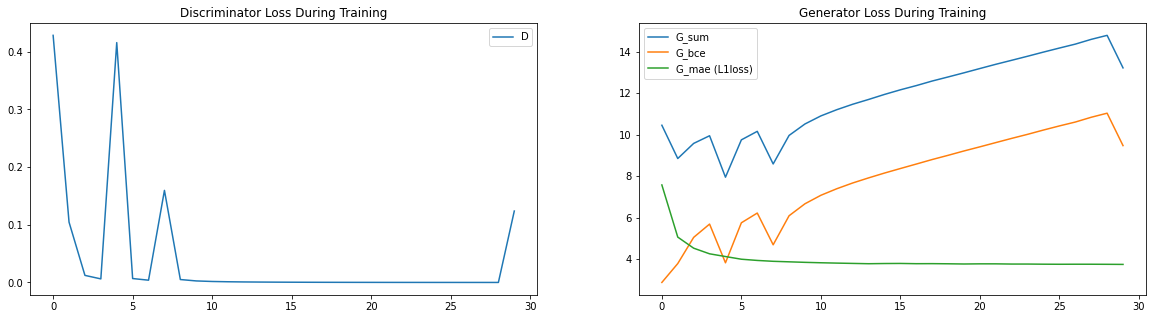

In [46]:
fig = plt.figure(figsize=(20,5))

ax1 = fig.add_subplot(1, 2, 1,  title="Discriminator Loss During Training")
ax2 = fig.add_subplot(1, 2, 2,  title="Generator Loss During Training")

ax1.plot(result["log_loss_D"],label="D")
ax1.legend()

ax2.plot(result["log_loss_G_sum"],label="G_sum")
ax2.plot(result["log_loss_G_bce"],label="G_bce")
ax2.plot(result["log_loss_G_mae"],label="G_mae (L1loss)")
ax2.legend()

## 予測

### 可視化

In [47]:
# 訓練のループ  
def test(epoch):
    # モデル
    torch.backends.cudnn.benchmark = True
    fake_agari_list = []

    # 訓練
    print("Starting Testining Loop...")

    # 生成器オブジェクトを作成する
    model_G = Generator().to(device)
    model_G.load_state_dict(torch.load(f"mahjong_gan/models/gen_{epoch:03}.pytorch"))

    # dataloader内の各バッチについて
    for agari, haipai in tqdm(test_dataloader):
        agari, haipai = agari.to(device), haipai.to(device)

        # 偽のカラー画像を作成
        fake_agari = model_G(haipai)

        # 偽画像を一時保存
        fake_agari_tensor = fake_agari.detach()
        fake_agari_list_batch = list(np.array(fake_agari_tensor.cpu()))
        fake_agari_list = fake_agari_list + fake_agari_list_batch

    return fake_agari_list

In [48]:
# モデルのロード
epoch = 20
fake_agari_list = test(epoch)

Starting Testining Loop...


100%|██████████| 158/158 [00:08<00:00, 19.07it/s]


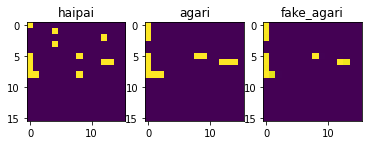

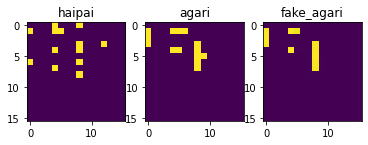

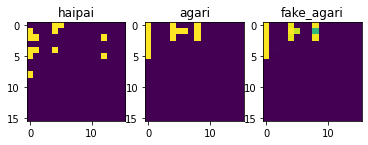

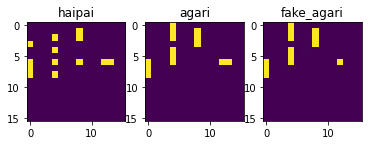

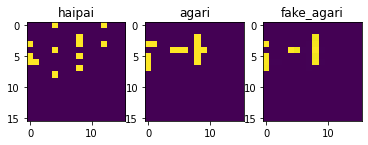

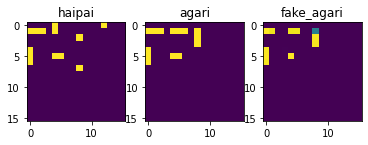

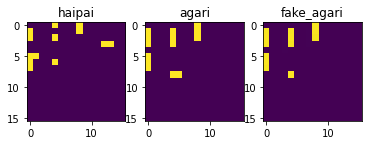

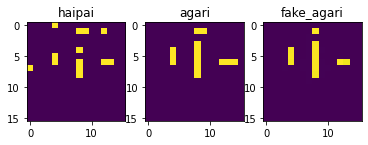

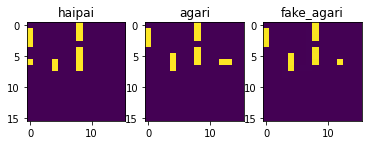

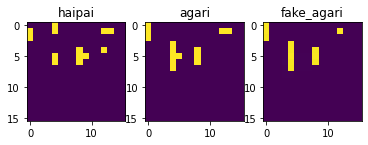

In [49]:
for i in range(10):
  fig = plt.figure()

  real_haipai = dataset_test[i][0].squeeze()
  ax1 = fig.add_subplot(1, 3, 1)
  ax1.imshow(real_haipai)
  ax1.set_title("haipai")

  real_agari = dataset_test[i][1].squeeze()
  ax2 = fig.add_subplot(1, 3, 2)
  ax2.imshow(real_agari)
  ax2.set_title("agari")

  fake_agari = fake_agari_list[i].squeeze()
  ax3 = fig.add_subplot(1, 3, 3)
  ax3.imshow(fake_agari)
  ax3.set_title("fake_agari")

### テンソルを手牌に戻す

In [50]:
def tensor_to_id(fake_agari):
  tehai_ar = fake_agari.squeeze()
  tehai_m = tehai_ar[0:9, 0:4].reshape(-1)
  tehai_p = tehai_ar[0:9, 4:8].reshape(-1)
  tehai_s = tehai_ar[0:9, 8:12].reshape(-1)
  tehai_z = tehai_ar[0:9, 12:16].reshape(-1)
  tehai_ar = np.concatenate([tehai_m, tehai_p, tehai_s, tehai_z])

  threshold = 0.5
  fake_agari_id = sorted([i for i, j in enumerate(tehai_ar) if j >= 0.5])

  return fake_agari_id

In [51]:
test_df["fake_agari_id"] = [tensor_to_id(i) for i in fake_agari_list]
test_df["fake_agari_hai_id"] = test_df.fake_agari_id.apply(lambda x: sorted([id_int >> 2 for id_int in x]))
test_df["fake_agari_str"] = test_df.fake_agari_id.apply(lambda x: [hai_convert_str(i) for i in x])

In [52]:
test_df.head()

,haipai_id,haipai_str,haipai_hai_id,agari_id,agari_str,agari_hai_id,fake_agari_id,fake_agari_hai_id,fake_agari_str
111907,"[2, 22, 24, 30, 33, 35, 41, 50, 92, 105, 116, 134, 135]","[一, 六, 七, 八, 九, 九, ②, ④, 6, 9, 西, 中, 中]","[0, 5, 6, 7, 8, 8, 10, 12, 23, 26, 29, 33, 33]","[2, 6, 11, 22, 24, 30, 32, 33, 35, 92, 94, 133, 134, 135]","[一, 二, 三, 六, 七, 八, 九, 九, 九, 6, 6, 中, 中, 中]","[0, 1, 2, 5, 6, 7, 8, 8, 8, 23, 23, 33, 33, 33]","[0, 4, 8, 20, 24, 28, 32, 33, 92, 132, 133]","[0, 1, 2, 5, 6, 7, 8, 8, 23, 33, 33]","[一, 二, 三, 六, 七, 八, 九, 九, 6, 中, 中]"
206923,"[5, 27, 37, 40, 43, 55, 64, 72, 84, 88, 96, 106, 123]","[二, 七, ①, ②, ②, ⑤, ⑧, 1, 4, 5, 7, 9, 北]","[1, 6, 9, 10, 10, 13, 16, 18, 21, 22, 24, 26, 30]","[5, 9, 15, 40, 41, 43, 52, 55, 84, 88, 93, 94, 96, 101]","[二, 三, 四, ②, ②, ②, ⑤, ⑤, 4, 5, 6, 6, 7, 8]","[1, 2, 3, 10, 10, 10, 13, 13, 21, 22, 23, 23, 24, 25]","[4, 8, 12, 40, 41, 52, 84, 88, 92, 96, 100]","[1, 2, 3, 10, 10, 13, 21, 22, 23, 24, 25]","[二, 三, 四, ②, ②, ⑤, 4, 5, 6, 7, 8]"
194744,"[7, 9, 11, 16, 18, 22, 35, 37, 39, 42, 54, 117, 128]","[二, 三, 三, 五, 五, 六, 九, ①, ①, ②, ⑤, 西, 發]","[1, 2, 2, 4, 4, 5, 8, 9, 9, 10, 13, 29, 32]","[2, 7, 9, 13, 16, 22, 37, 41, 42, 43, 45, 72, 78, 81]","[一, 二, 三, 四, 五, 六, ①, ②, ②, ②, ③, 1, 2, 3]","[0, 1, 2, 3, 4, 5, 9, 10, 10, 10, 11, 18, 19, 20]","[0, 4, 8, 12, 16, 20, 36, 40, 41, 44, 72, 76, 80]","[0, 1, 2, 3, 4, 5, 9, 10, 10, 11, 18, 19, 20]","[一, 二, 三, 四, 五, 六, ①, ②, ②, ③, 1, 2, 3]"
256082,"[15, 27, 28, 35, 44, 54, 63, 69, 78, 80, 99, 133, 135]","[四, 七, 八, 九, ③, ⑤, ⑦, ⑨, 2, 3, 7, 中, 中]","[3, 6, 7, 8, 11, 13, 15, 17, 19, 20, 24, 33, 33]","[27, 28, 35, 37, 42, 44, 54, 56, 63, 78, 80, 85, 133, 135]","[七, 八, 九, ①, ②, ③, ⑤, ⑥, ⑦, 2, 3, 4, 中, 中]","[6, 7, 8, 9, 10, 11, 13, 14, 15, 19, 20, 21, 33, 33]","[24, 28, 32, 36, 40, 44, 52, 56, 60, 76, 80, 84, 132]","[6, 7, 8, 9, 10, 11, 13, 14, 15, 19, 20, 21, 33]","[七, 八, 九, ①, ②, ③, ⑤, ⑥, ⑦, 2, 3, 4, 中]"
202581,"[14, 21, 24, 27, 36, 53, 71, 83, 85, 95, 101, 109, 122]","[四, 六, 七, 七, ①, ⑤, ⑨, 3, 4, 6, 8, 東, 北]","[3, 5, 6, 6, 9, 13, 17, 20, 21, 23, 25, 27, 30]","[12, 14, 21, 24, 29, 53, 54, 55, 83, 85, 88, 89, 95, 99]","[四, 四, 六, 七, 八, ⑤, ⑤, ⑤, 3, 4, 5, 5, 6, 7]","[3, 3, 5, 6, 7, 13, 13, 13, 20, 21, 22, 22, 23, 24]","[12, 20, 24, 28, 52, 53, 80, 84, 88, 92, 96]","[3, 5, 6, 7, 13, 13, 20, 21, 22, 23, 24]","[四, 六, 七, 八, ⑤, ⑤, 3, 4, 5, 6, 7]"


### accuracyの計算

In [53]:
mlb = MultiLabelBinarizer()

y_true = mlb.fit_transform(test_df.agari_hai_id)
y_pred = mlb.transform(test_df.fake_agari_hai_id)

In [56]:
# macro-F1
average = "macro"
print("Precisionの平均：", precision_score(y_true=y_true, y_pred=y_pred, average=average))
print("Recallの平均：", recall_score(y_true=y_true, y_pred=y_pred, average=average))
print("macro-F1", f1_score(y_true=y_true, y_pred=y_pred, average=average))

Precisionの平均： 1.0
Recallの平均： 0.994276321546359
macro-F1 0.9971233558893569


In [58]:
# micro-F1
average = "micro"
print("Precisionの平均：", precision_score(y_true=y_true, y_pred=y_pred, average=average))
print("Recallの平均：", recall_score(y_true=y_true, y_pred=y_pred, average=average))
print("micro-F1", f1_score(y_true=y_true, y_pred=y_pred, average=average))

Precisionの平均： 1.0
Recallの平均： 0.993408166475921
micro-F1 0.9966931842484961
